# Séance 1 - Réseau de neurones dense

On se propose de classifier les chiffres manuscrit du dataset [MNIST](https://yann.lecun.com/exdb/mnist/) en définissant ses propres réseaux de neurones denses. L'objectif est de découvrir la manière d'entraîner ces algorithmes et observer en pratique les bases théoriques discutées en cours.

## Exploration des données

Commençons par importer les données.

In [32]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

(X_train_full, y_train_full), (X_test, y_test) = (keras.datasets.mnist.load_data())

**Consigne** : À l'aide de la fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), séparer le jeu d'entraînement complet en un dataset d'entraînement et un dataset de validation. Afficher les tailles des datasets respectifs.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

for (dataset, name) in zip([X_train, X_valid, X_test], ["Train", "Validation", "Test"]):
  print(name, ":", dataset.shape)

Train : (48000, 28, 28)
Validation : (12000, 28, 28)
Test : (10000, 28, 28)


**Consigne** : Afficher plusieurs images du dataset d'entraînement aléatoirement. On pourra utiliser la fonction [`imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).

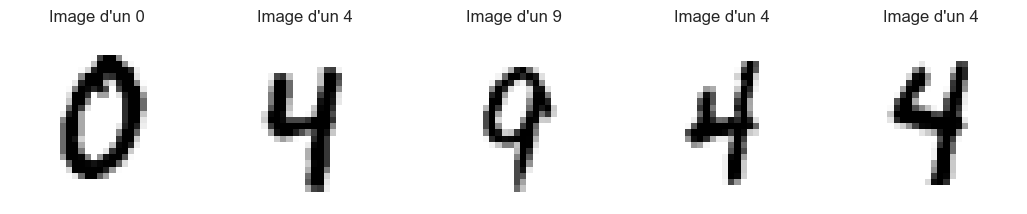

In [34]:
n = 5

plt.figure(figsize=(13, 6))
for plot_index in range(1, n+1):
  plt.subplot(1, n, plot_index)
  index = np.random.randint(low=0, high=len(X_train))
  plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
  plt.title("Image d'un %d" % y_train[index])
  plt.axis('off')
plt.show()

Les images sont en niveau de gris, donc de valeurs entre 0 et 255. Pour entraîner correctement un réseau de neurones, il est préférable que les inputs soit standardisés.

**Consigne** : Standardiser les données en utilisant la classe [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). On commencera par applatir les images en utilisant la méthode [`reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html), puis on applique le pré-processing et on termine par reformer la matrice.

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

## Modélisation du réseau de neurones

Pour le moment, nous travaillons avec des images de tailles $28\times28$, mais nous ne savons pas définir (pour le moment) de réseau de neurones capable de travailler directement avec une image. Nous allons utiliser une couche nommée [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) dont le but est *d'applatir* une matrice de dimension *(height, width, channel)* en un vecteur de taille *height $\times$ width $\times$ channel*. Dans le cadre des données MNIST, *channel*=1 puisque nous sommes en niveau de gris, et *height=width=28*. On aura un vecteur de 784 dimensions.

Une fois que nous aurons décrit l'ensemble du réseau, nous devrons terminer le réseau par une couche avec dix neurones : un pour chaque classe. Pour s'assurer que l'on aura une estimation de probabilité d'appartenance à la classe, on utilisera la fonction softmax. Pour un vecteur $x = (x_0, x_1, \ldots, x_n)$ on a:

$$\text{softmax}(x)_j = \frac{e^{x_j}}{\displaystyle \sum_{i=0}^n e^{x_i}}$$

On veut définir le réseau suivant:
* **Couche cachée 1** : 256 neurones avec fonction d'activation ReLU
* **Couche cachée 2** : 128 neurones avec fonction d'activation ReLU

On peut définir de plusieurs manières un réseau de neurones. La première est de la même manière qu'une liste à laquelle on ajoute des couches en utilisation le template de modèle *Sequential* :

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[28, 28]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

En début de réseau de neurones on doit définir la dimension de l'input: ici (28, 28). Le reste des dimensions pour l'ensemble des couches qui lui succède sont calculées automatiquement.

La deuxième manière est directement sous le format d'une liste:

In [37]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

**Consigne** : Calculer à la main le nombre de neurones du modèle, couche par couche. Puis utiliser la méthode [`summary`](https://keras.io/api/models/model/#summary-method) pour vérifier les calculs.

On s'attend à :
* Pour la couche cachée 1 : 256 neurones connectés à 784 input. Ainsi : 256 * (784 + 1) = 200960 paramètres
* Pour la couché cachée 2 : 128 neurones connectés à 256 inputs. Ainsi : 128 * (256 + 1) = 32896 paramètres
* Pour la dernière couche : 10 neurones connectés à 128 inputs. Ainsi : 10 * (128 + 1) = 1290 paramètres

Au total on a donc 235146 paramètres dans ce réseau ! Vérifions :

In [38]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_16 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Nous avons décrit l'architecture du réseau de neurones. Il faut maintenant définir comment il va s'entraîner. Nous devons spécifier:

* **Loss** : Quelle fonction de perte est à minimiser ?
* **Optimizer** Quel schéma de descente de gradient est à utiliser ?
* **Metrics** : Quelles métrique de performance souhaite-on observer pendant l'entraînement ?

Puisque nous travaillons sur un problème de classification avec plusieurs classes, la fonction de perte [`sparse_categorical_crossentropy`](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) est celle qu'il nous faut.

Concernant l'*optimizer* il y a plusieurs possibilités que nous verrons dans une prochaine séance. Pour le moment nous travaillerons avec une descente de gradient stochastique par mini-batch [`SGD`](https://keras.io/api/optimizers/sgd/). Pour la définir, nous devons statuer sur:
* **Learning rate** : pas de descente, on décide de choisir la valeur 0.001
* **Batch size** : nombre d'observations à considérer pour chacune des passes. On décide de prendre 32 images par batch. Cette valeur sera à renseigner un peu plus tard.

Pour les métriques, nous suivrons l'accuracy parce que la distribution des catégories à prédire n'est pas déséquilibrées.

In [39]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

## Entraînement

Le modèle est maintenant prêt à être entraîné, il nous reste à lui indiquer:
* **Données** : jeu d'entraînement et jeu de validation
* **Époques** : le nombre de passes à réaliser sur l'ensemble du dataset
* **Batch size** : le nombre d'observations pour chaque batch, nous avions décidé juste avant que ce serait 32

In [40]:
epochs = 5
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4138 - loss: 1.8457 - val_accuracy: 0.8102 - val_loss: 0.7909
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8325 - loss: 0.6830 - val_accuracy: 0.8723 - val_loss: 0.4929
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8803 - loss: 0.4498 - val_accuracy: 0.8925 - val_loss: 0.3958
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8981 - loss: 0.3720 - val_accuracy: 0.9032 - val_loss: 0.3474
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9064 - loss: 0.3329 - val_accuracy: 0.9114 - val_loss: 0.3165


Nous avons des informations disponible dans l'objet *history*, plus précisement dans *history.history*

**Consigne** : Créer un [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) à partir de *history.history* puis inspecter-le.

In [41]:
historic = pd.DataFrame(history.history)
historic.head()

,accuracy,loss,val_accuracy,val_loss
0,0.603000,1.385735,0.810167,0.790950
1,0.847562,0.606559,0.872333,0.492874
2,0.883937,0.432055,0.892500,0.395847
3,0.899312,0.360010,0.903250,0.347409
4,0.909208,0.318126,0.911417,0.316511


**Consigne**: Définir une fonction `plot_learning_curves` qui prend en paramètre l'objet *history* et qui renvoie un graphique. Le graphique correspondra à deux graphiques côte à côte :
1. Le premier montre l'évolution de la fonction de perte en fonction des époques
2. Le second montre l'évolution de l'accuracy en fonction des époques
Dans les deux cas, les valeurs de performance sur le dataset de validation doivent être en pointillé. 

In [42]:
def plot_learning_curves(history, figsize=(13, 6)):
    historic = pd.DataFrame(history.history)
    epochs = [epochs for epochs in range(1, historic.shape[0]+1)]
    
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, historic["loss"])
    plt.plot(epochs, historic["val_loss"], ls='--')
    plt.xlabel("Epoch")
    plt.ylim(bottom=0)
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, historic["accuracy"])
    plt.plot(epochs, historic["val_accuracy"], ls='--')
    plt.xlabel("Epoch")
    plt.ylim(0, 1)
    plt.title("Accuracy")

    plt.suptitle("Performances through training")
    plt.show()

**Consigne** : Exploiter la fonction précédente pour observer les courbes d'apprentissage du l'entraînement précédent.

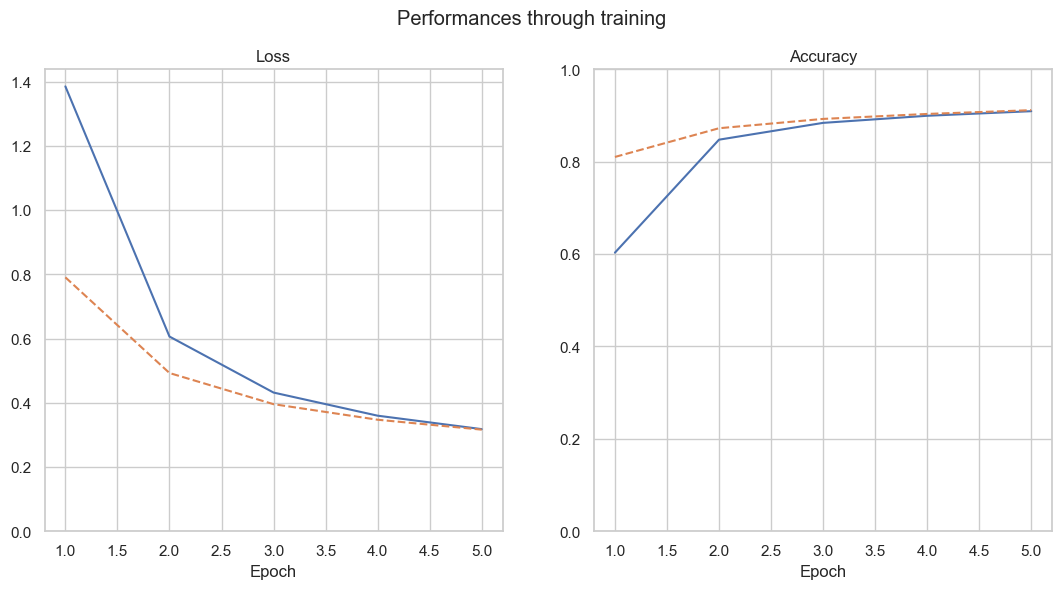

In [43]:
plot_learning_curves(history)

## Exploitation des prédictions

On souhaite à présent utiliser le modèle pour prédire le chiffre présent dans une image.

**Consigne** : Prédire sur le jeu de test à l'aide de la méthode [`predict`](https://keras.io/api/models/model_training_apis/#predict-method), puis observer le résultat sur la première image.

In [44]:
y_pred = model.predict(X_test)
print(y_pred[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
[1.3101746e-05 8.1478938e-06 8.3343999e-05 4.6577453e-04 9.0377944e-06
 2.6366088e-05 1.1440286e-06 9.9850047e-01 4.2727548e-05 8.4993365e-04]


**Consigne** : Après avoir vérifier que si l'on somme les chiffres affichés pour la première image vaut bien 1, identifier la classe prédite par le modèle. Vérifier visuellement.

Avec une valeur de ~0.99, la classe 7 semble être celle qui est la plus probable selon le modèle. Vérifions :

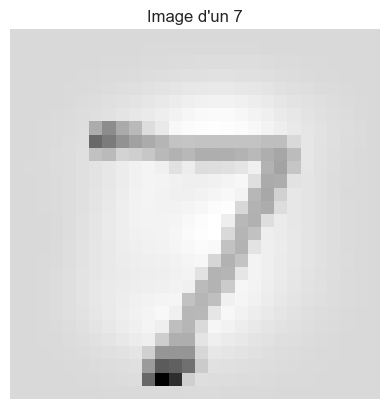

In [45]:
plt.imshow(X_test[0], cmap="binary", interpolation="nearest")
plt.title("Image d'un %d" % y_test[0])
plt.axis('off')
plt.show()

## Quel est l'impact du learning rate ?

On s'intéresse à présent à l'importance du choix du learning rate. On se propose de tester plusieurs valeurs pour obtenir les meilleurs performances.

**Consigne** : Définir une fonction `get_model` qui prend en paramètre un `float` qui correspond à un learning rate. La fonction renvoie un modèle compilé avec les mêmes paramètres que précédemment, sauf la valeur du learning rate qui est renseignée par l'utilisateur.

In [46]:
def get_model(learning_rate=1e-4):
    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
    return model

Avant de lancer sur plusieurs époques, commençons par écrire une ébauche de la boucle de comparaison avec 5 époques.

In [47]:
n_epochs = 5
batch_size = 32
learning_rates = [10**(-power) for power in range(1, 4)]

results = []
for learning_rate in learning_rates:
  print("Learning rate: %f - époques: %d" % (learning_rate, n_epochs))
  model = get_model(learning_rate=learning_rate)
  history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))
  result = {"learning_rate": learning_rate, "history": pd.DataFrame(history.history)}
  results.append(result)

Learning rate: 0.100000 - époques: 5
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8830 - loss: 0.4201 - val_accuracy: 0.9541 - val_loss: 0.1736
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9657 - loss: 0.1316 - val_accuracy: 0.9617 - val_loss: 0.1410
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9803 - loss: 0.0722 - val_accuracy: 0.9624 - val_loss: 0.1477
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9852 - loss: 0.0511 - val_accuracy: 0.9666 - val_loss: 0.1344
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9912 - loss: 0.0322 - val_accuracy: 0.9688 - val_loss: 0.1365
Learning rate: 0.010000 - époques: 5
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7837 - loss: 0.7738 - val_accuracy: 0.9215 - val_loss: 0.2641
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9395 - loss: 0.2071 - val_accuracy: 0.9482 - val_loss: 0.1917
Epoch 3/5
1500/1500 ━━━

**Consigne** : Définir une fonction `show_results` qui prend en paramètre l'objet *results* construit précédemment et qui renvoie un graphique similaire à celui renvoyé par `plot_learning_curves`. Cependant, les différentes itérations doivent être présente sur chaque graphique, ici les courbes d'entraînement pour chaque learning rate, avec la bonne légende pour chaque graphique.

In [48]:
def show_results(results, figsize=(15, 6)):
    n_epochs = results[0]["history"].shape[0]
    epochs = range(1, n_epochs+1)

    figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=figsize)

    for index, result in enumerate(results):
        color = sns.color_palette()[index]
        history = result["history"]
        plt.subplot(1, 2, 1)
        axis_1.plot(epochs, history["loss"], label="LR: %0.4f" % result["learning_rate"], color=color)
        axis_1.plot(epochs, history["val_loss"], '--', color=color)

        axis_2.plot(epochs, history["accuracy"], label="LR: %0.4f" % result["learning_rate"], color=color)
        axis_2.plot(epochs, history["val_accuracy"], '--', color=color)

    axis_1.set_ylim(bottom=0)
    axis_2.set_ylim(0, 1)
    for axis in [axis_1, axis_2]:
        axis.set_xlabel("Epochs")
        axis.legend()

    axis_1.set_ylabel("Loss")
    axis_1.set_title("Loss for different learning rates")

    axis_2.set_ylabel("Accuracy")
    axis_2.set_title("Accuracy for different learning rates")

    plt.show()

**Consigne**: Lancer l'entraînement pour plus d'époques afin de comparer avec la fonction `show_results` les différences d'entraînement. Commenter.

Pour gagner du temps, on pourra augmenter le batch_size à 256 voire 528. Pour éviter de surcharger l'affichage, on peut utiliser le paramètre *verbose* de la méthode `fit` : s'il vaut 0 alors il n'y a aucun affichage.

Learning rate: 0.100000 - époques: 100
Learning rate: 0.010000 - époques: 100
Learning rate: 0.001000 - époques: 100


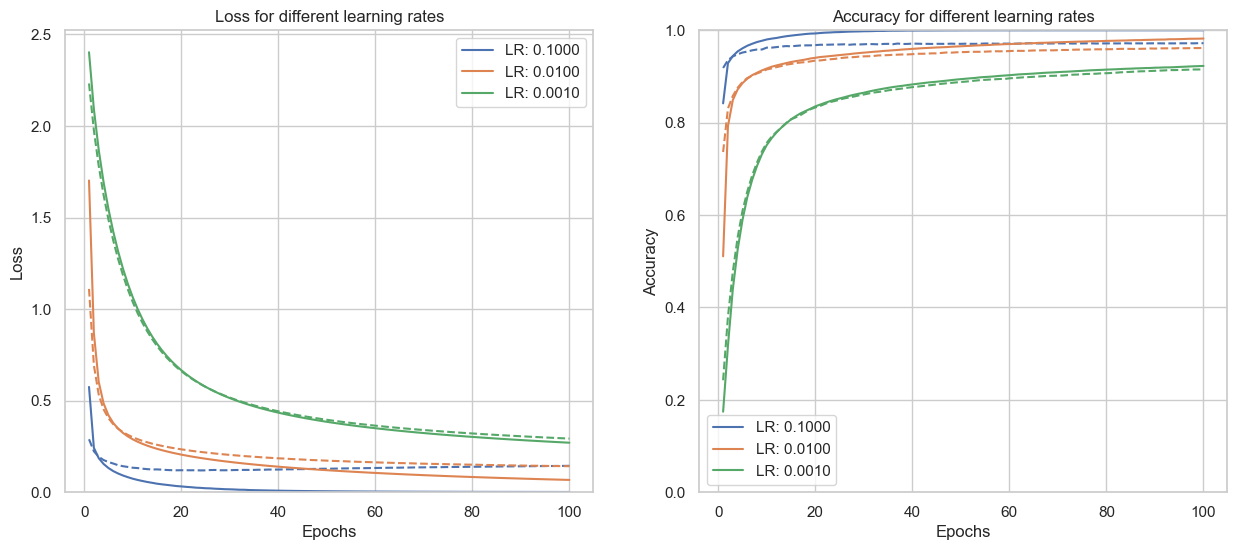

In [49]:
n_epochs = 100
batch_size = 528
learning_rates = [10**(-power) for power in range(1, 4)]

results = []
for learning_rate in learning_rates:
  print("Learning rate: %f - époques: %d" % (learning_rate, n_epochs))
  model = get_model(learning_rate=learning_rate)
  history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)
  result = {"learning_rate": learning_rate, "history": pd.DataFrame(history.history)}
  results.append(result)

show_results(results)

## Pour continuer

Choisir une ou plusieurs pistes de recherche parmi les suivantes. Il est possible de choisir une autre direction, mais elle doit être validé auparavant.

1. L'initialisation des réseaux de neurones étant aléatoire, et la mise à jour des poids étant réalisées avec SGD, on ne peut pas considérer un exemple comme une généralité. Reproduire l'étude précédente en lançant plusieurs fois le même modèle pour être capable de générer un graphique avec des intervalles de confiance.
2. Nous avons vu en cours que l'initialisation des poids peut avoir un impact fort sur la suite de l'entraînement. En exploitant le paramètre `kernel_initializer` présent dans la définition de la couche [`Dense`](https://keras.io/api/layers/core_layers/dense/), proposer et réaliser une étude pour vérifier ou infirmer cela.
3. Les réseaux de neurones peuvent sur-apprendre. Il est important de pouvoir les régulariser. En exploitant le paramètre `kernel_regularizer` présent dans la définition de la couche [`Dense`](https://keras.io/api/layers/core_layers/dense/), proposer une étude pour visualiser son impact sur l'apprentissage.